In [21]:
import pandas as pd
import numpy as np
import haversine as hs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv("uber.csv")
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [3]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [4]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])
if 'key' in df.columns:
    df = df.drop(columns=['key'])


In [5]:
df = df.dropna(subset=['pickup_datetime', 'pickup_longitude', 'pickup_latitude',
                       'dropoff_longitude', 'dropoff_latitude', 'fare_amount'])


In [6]:
df = df[df['fare_amount'] > 0]

In [7]:
if 'passenger_count' in df.columns:
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

In [8]:
df = df[
    (df['pickup_latitude'].between(-90, 90)) &
    (df['dropoff_latitude'].between(-90, 90)) &
    (df['pickup_longitude'].between(-180, 180)) &
    (df['dropoff_longitude'].between(-180, 180))
]

In [9]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna(subset=['pickup_datetime'])


In [10]:
df['hour'] = df['pickup_datetime'].dt.hour
df['day'] = df['pickup_datetime'].dt.day
df['month'] = df['pickup_datetime'].dt.month
df['year'] = df['pickup_datetime'].dt.year
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

In [11]:
def calc_distance(lat1, lon1, lat2, lon2):
    return hs.haversine((lat1, lon1), (lat2, lon2))

# Vectorized computation for speed
df['distance_km'] = np.vectorize(calc_distance)(
    df['pickup_latitude'], df['pickup_longitude'],
    df['dropoff_latitude'], df['dropoff_longitude']
)


In [12]:
print(df['distance_km'].describe())

count    199256.000000
mean         20.320863
std         376.848525
min           0.000000
25%           1.215422
50%           2.121969
75%           3.875872
max        8782.910738
Name: distance_km, dtype: float64


In [13]:
df = df[(df['distance_km'] > 0) & (df['distance_km'] < 100)]
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 500)]

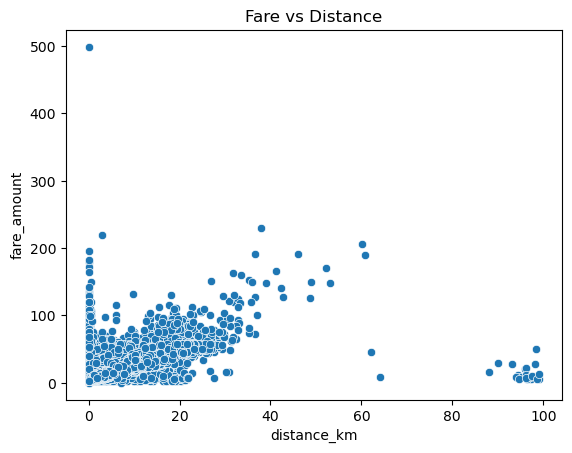

In [14]:
sns.scatterplot(x='distance_km', y='fare_amount', data=df)
plt.title("Fare vs Distance")
plt.show()

In [15]:
feature_cols = ['distance_km', 'hour', 'passenger_count'] if 'passenger_count' in df.columns else ['distance_km', 'hour']
X = df[feature_cols]
y = df['fare_amount']


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
y_pred = model.predict(X_test)
print("\nModel Evaluation:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))



Model Evaluation:
Mean Absolute Error (MAE): 2.445938727594997
R² Score: 0.6856497765081091


In [26]:
rf_model = RandomForestRegressor(n_estimators=100)


In [27]:
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

In [28]:
mae_rf

2.576027004352868

In [30]:
r2_rf

0.6986487030951573